## Probabilistic Programming in Python

- PyStan (Market Leader - Lower Level than PyMC - MCMC mostly)
- PyMC (MCMC, No-U-Turn sampler (NUTS; Hoffman 2014), self-tuning variant of HMC(HMC; Duane 1987).
- Pyro/NumPyro (more towards variational inference side)
- Tensorflow Probablity 
- Edward 
- emcee 

NUTS and HMC: This class of samplers work well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information form the likleihood to achieve much faster convergence than tradiditi


PyMC :
- Fits Bayesian statistical models with MCMC, variational inference and other algorithms
- Includes a large suite of well-documented statitical distributions
- Leverages ArviZ for convergence diagnostics, model checking methods and creating summaries including tables and plots. 
- Extensible: easily incorporates custom step methods and unusual probability distributions
- Non-parametric Bayesian methods, including Gausian Process, and Dirichlet process, are supported.

Consider a simple Bayesian linear regression model with normally-distributed priors for the parameters:

$$Y~N(\mu, \sigma^2)$$
$$\mu = \alpha + \beta_1X_1 \beta_2X_2$$

with $\alpha$ intercept, $\beta_i$ coefficients for covariate $X_i$, while $\sigma$ is the observation error. Under the Bayesian approach, we assign prir distributions to the parameters:

$$\alpha ~ N(0,100)$$
$$ \beta_i ~ N(0,100)$$
$$ \sigma ~ N(0,1)$$

We can implement this model in pymc as follows:

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

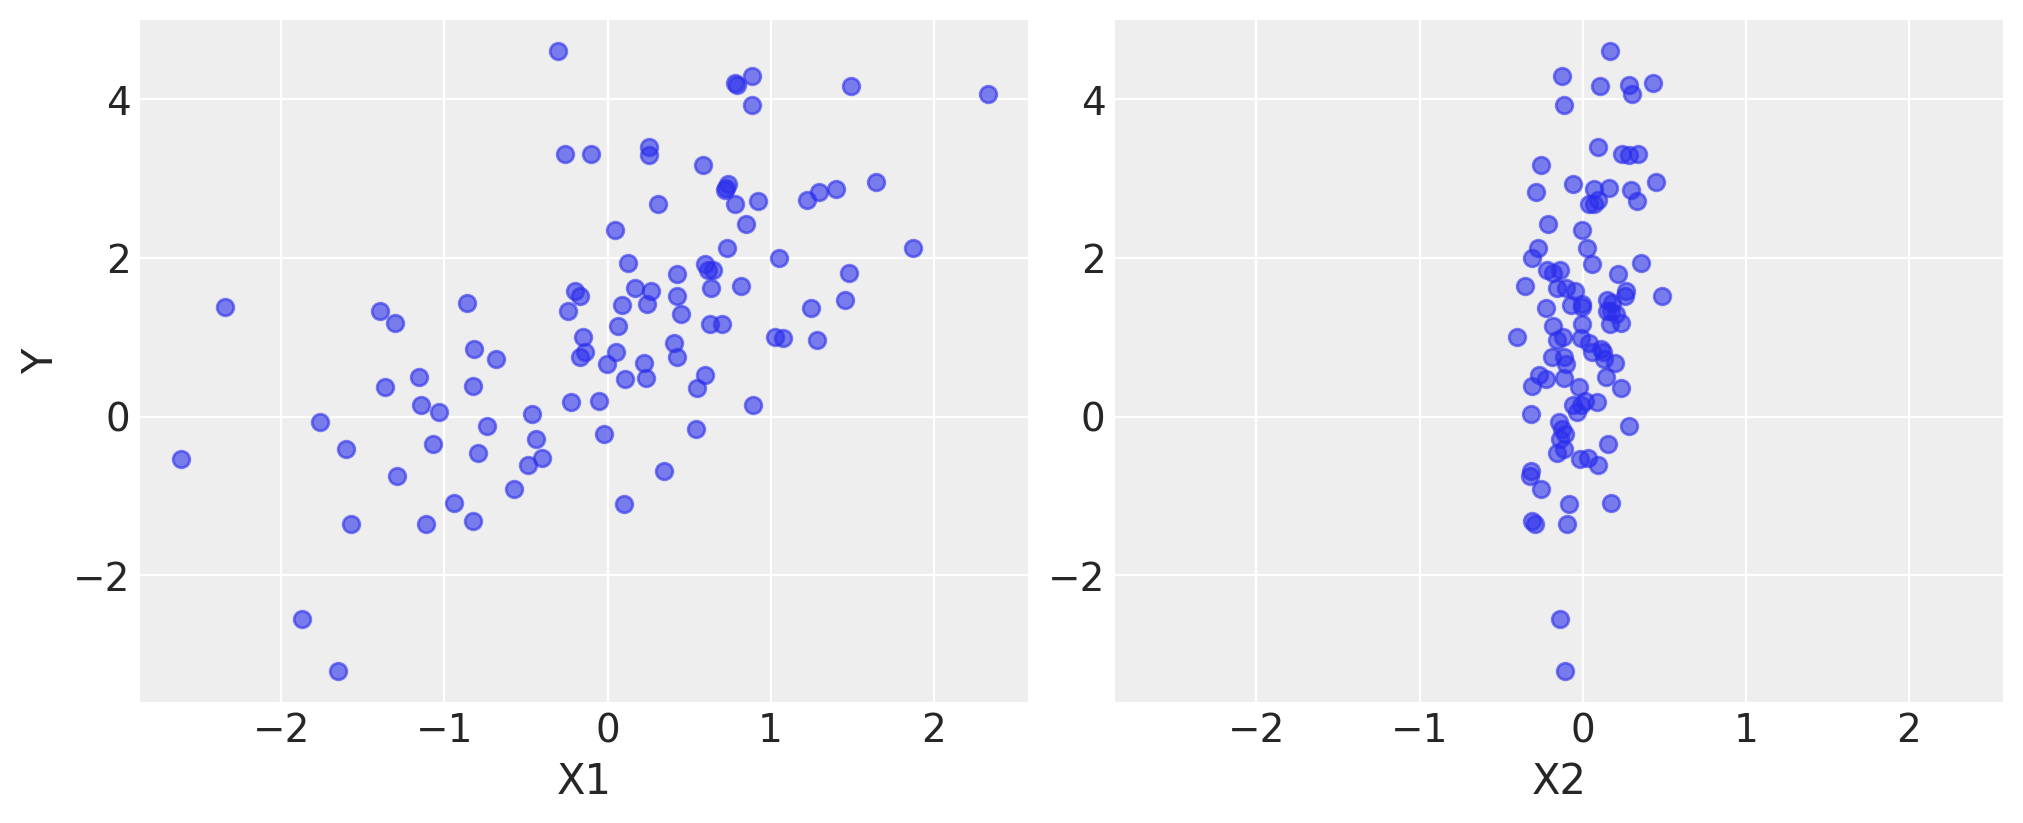

In [4]:
#We can simulate some artificial data from this model
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
import pymc as pm

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Important difference with other packages is that pymc works with context managers when specifying model. This means all PyMC objects introduced in the indented code block below the with statement are added to the model behind the scenes.

### Stochastic random variables, Deterministic random variables and Observed Stochastic

The parameters, and their respective parameters, are specified as:

```
alpha = pm.Normal('alpha', mu=0, sigma=10)
beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
sigma = pm.HalfNormal('sigma', sigma=1)
```

These are **stochastic random variables** because their values are partly determined by their parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

Next the epcected value $\mu$ is specified via the linear relationship:
```
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic random variable**, which implies that its value is completely determined by its parents’ values. 

Finally , the observed data is introduced into the model via: 
```
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `ndarray` or `DataFrame` object.

## Sampling from the posterior using Monet Carlo Method

The `sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an `InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that sample generated a set of parallel chains, depending on how many compute cores are on your machine.

This is done again inside a context manager:

In [6]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The `InferenceData` object has a lot of information when printed:

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Note that this sampling was done using the default arguments for the sample method; these arguments include specifying options like which Monte Carlo method to use, the tuning-parameters for these methods etc. In the default case above the NUTS monte carlo method is used.

In [7]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 2, draw: 5)>
array([[1.12265114, 1.1001654 , 1.15173743, 1.18517763, 0.97534966],
       [1.01843063, 1.22712031, 1.14760597, 1.14130459, 1.22879804]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4

## Posterior Analysis

PyMC’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named Arviz:

/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


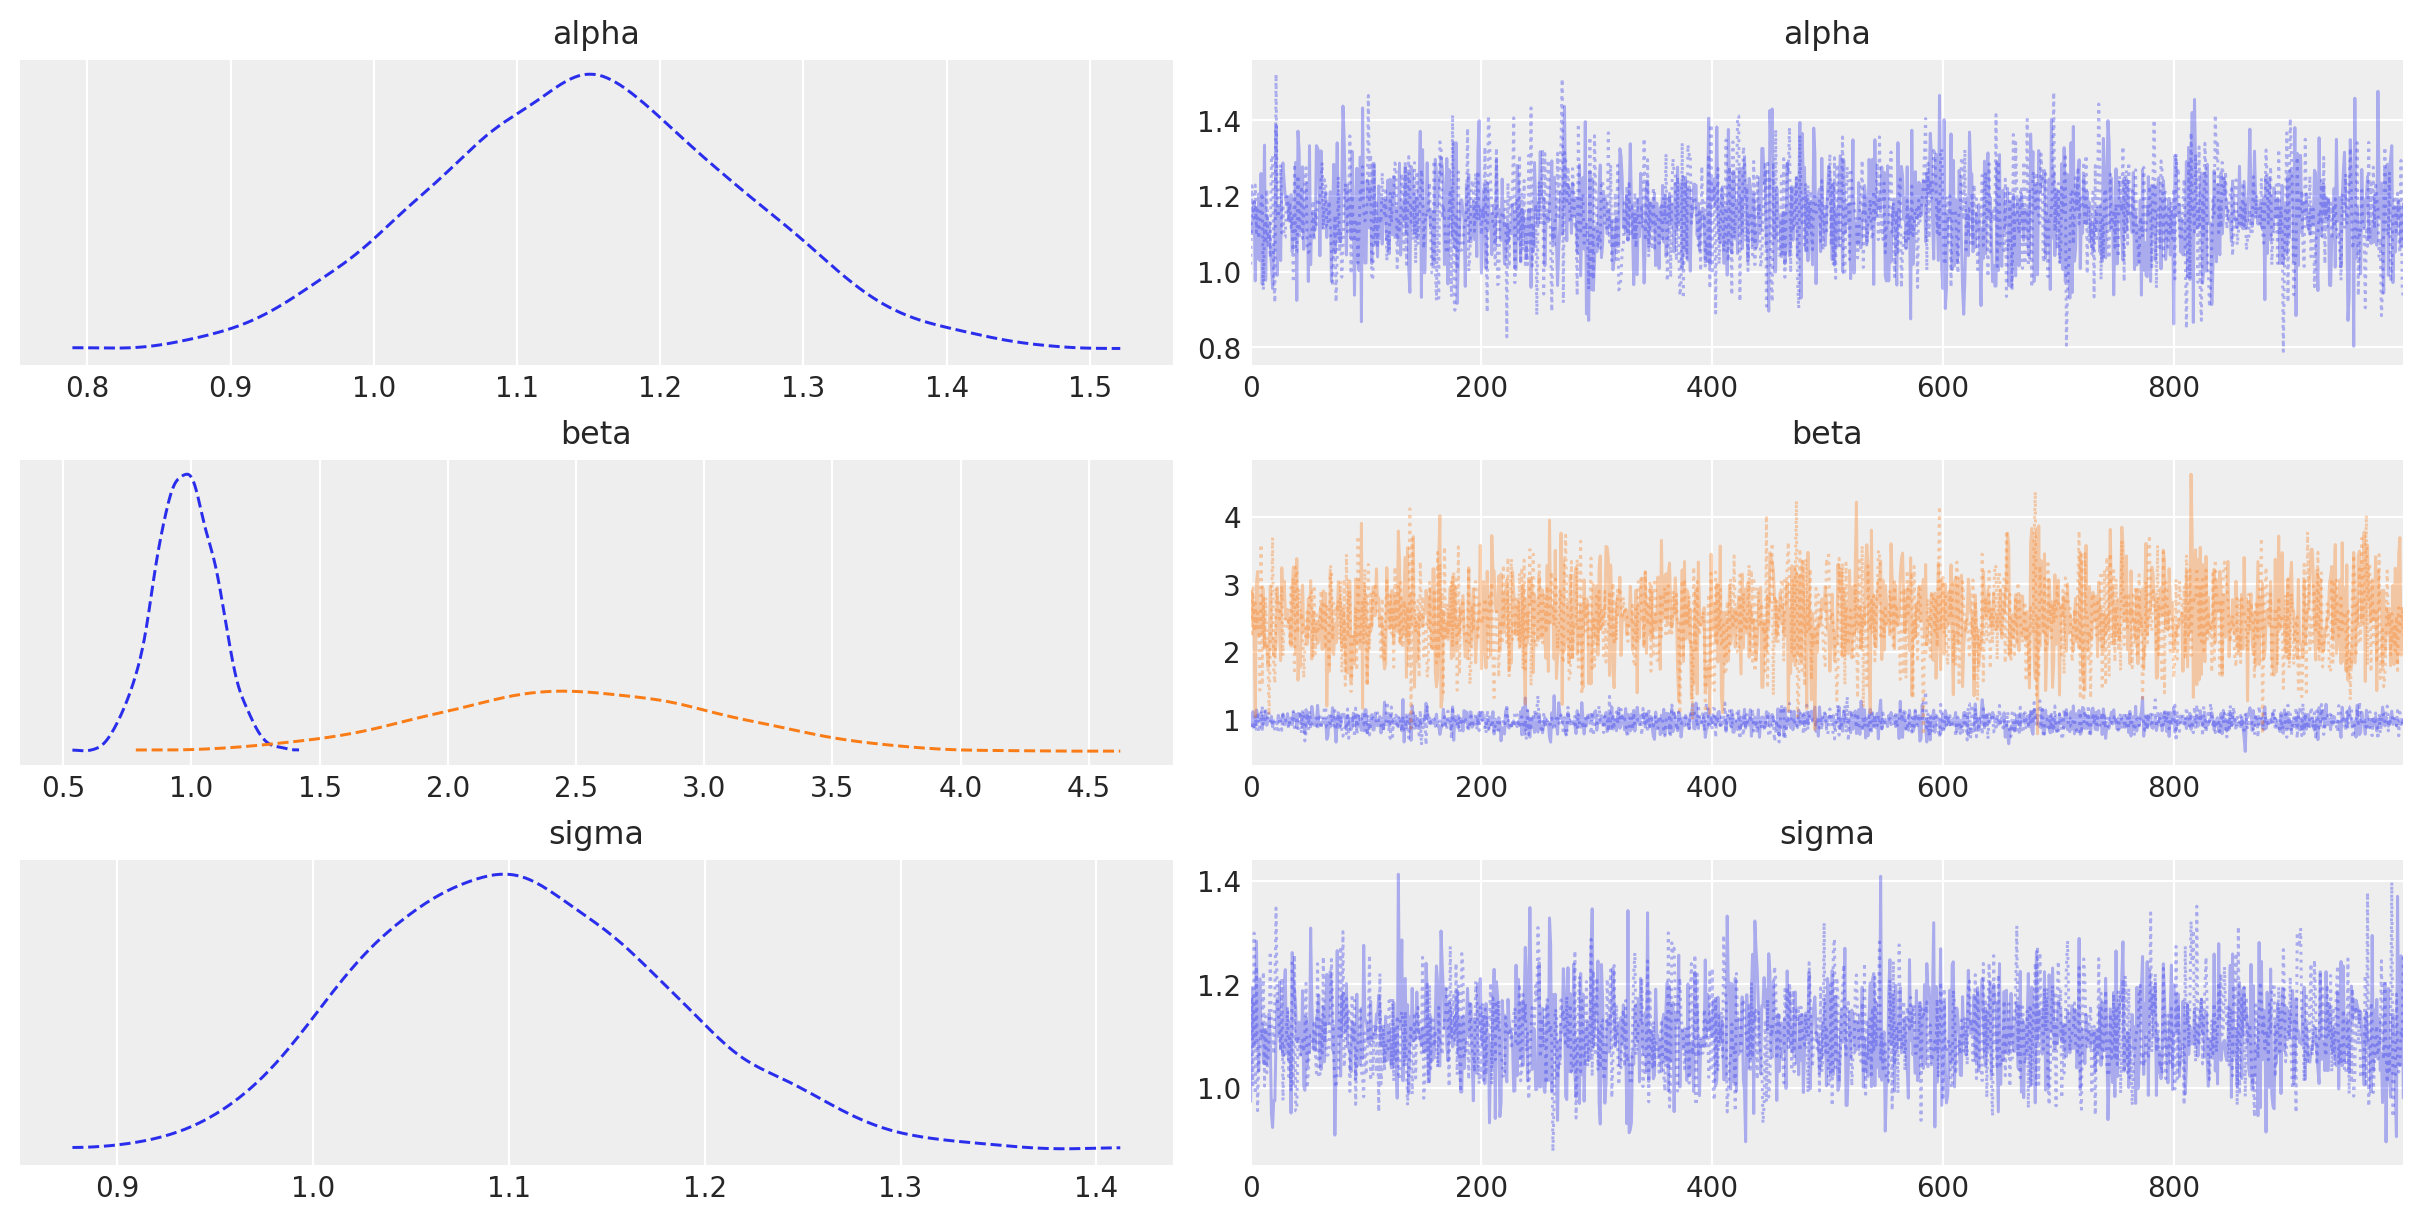

In [9]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [10]:
az.summary(idata, round_to=2)

/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.11,0.93,1.34,0.00,0.00,2668.65,1603.11,1.0
beta[0],0.98,0.12,0.74,1.19,0.00,0.00,2910.31,1834.48,1.0
beta[1],2.50,0.56,1.43,3.53,0.01,0.01,2441.64,1571.28,1.0
sigma,1.11,0.08,0.97,1.26,0.00,0.00,2546.28,1533.06,1.0


TODO: Look at the two case studies and add any relevant information

##  Prior and Posterior Predictive Checks:

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a ‘sense check’ or explaining your model to others and getting criticism.

Prior predictive checks are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

They allow you to check whether you are indeed incorporating scientific knowledge into your model – in short, they help you check how credible your assumptions before seeing the data are.

They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.